# Cración de portafolio con CDARS

In [ ]:
!pip install yfinance;

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np

Definimos con cuales tickers queremos crear el portafolio

In [ ]:
tickers = [
  'AAPL',
  'MELI',
  'INTC',
  'KO',
  'GOOGL',
  'MSFT'
]

Buscamos la data de precios de los ultimos 2 años

In [ ]:
tickers_cdars = [f'{ticker}.BA' for ticker in tickers]

In [ ]:
prices_usd = yf.download(" ".join(tickers), period = '2y', interval = '1d').Close

[*********************100%***********************]  6 of 6 completed


In [ ]:
prices_usd.head(5)

,AAPL,GOOGL,INTC,KO,MELI,MSFT
Date,,,,,,
2018-10-26,54.075001,1083.750000,45.689999,45.919998,295.369995,106.959999
2018-10-29,53.060001,1034.729980,45.400002,46.459999,287.339996,103.849998
2018-10-30,53.325001,1049.510010,47.759998,47.630001,310.410004,103.730003
2018-10-31,54.715000,1090.579956,46.880001,47.880001,324.500000,106.809998
2018-11-01,55.555000,1085.979980,48.220001,47.740002,341.649994,105.919998


In [ ]:
prices_ars = yf.download(tickers_cdars, period = '2y', interval = '1d').Close

[*********************100%***********************]  6 of 6 completed


In [ ]:
prices_ars.head(5)

,AAPL.BA,GOOGL.BA,INTC.BA,KO.BA,MELI.BA,MSFT.BA
Date,,,,,,
2018-10-26,203.50,1380.0,356.000000,336.149994,5500.250000,780.000000
2018-10-29,196.25,1380.0,339.850006,346.000000,5350.000000,765.000000
2018-10-30,195.00,1380.0,339.850006,350.000000,5749.100098,754.200012
2018-10-31,197.50,1380.0,339.850006,349.500000,5900.000000,789.000000
2018-11-01,198.00,1380.0,339.850006,341.049988,6145.000000,770.000000


In [ ]:
prices_ars.isnull().sum(), prices_usd.isnull().sum()

(AAPL.BA     0
 GOOGL.BA    0
 INTC.BA     0
 KO.BA       0
 MELI.BA     0
 MSFT.BA     0
 dtype: int64, AAPL     0
 GOOGL    0
 INTC     0
 KO       0
 MELI     0
 MSFT     0
 dtype: int64)

Visualizamos los retornos de cada acción en dolares de forma diaria y normalizada y acumulativa normnalizada

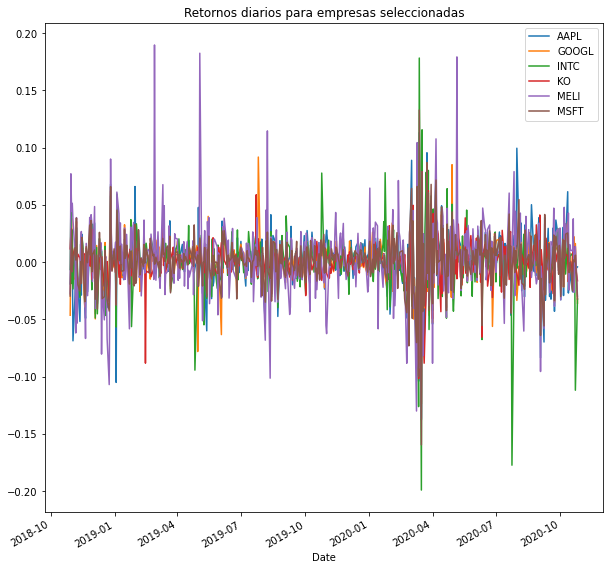

In [ ]:
returns_usd = prices_usd.apply(np.log).diff(1) 
returns_usd.plot(title='Retornos diarios para empresas seleccionadas', figsize = (10, 10))

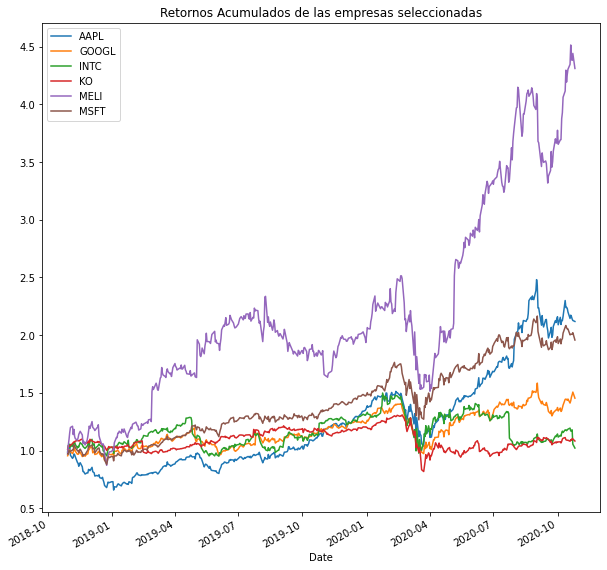

In [ ]:
cumulative_returns_usd = returns_usd.cumsum().apply(np.exp)
cumulative_returns_usd.plot(title='Retornos Acumulados de las empresas seleccionadas', figsize = (10, 10))

Divido la data en dos partes iguales

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(returns_usd, train_size = 0.5, shuffle = False)

Para el modelo utilizo desde finales 2018 hasta finales 2019

In [ ]:
train.index[0], train.index[-1]

(Timestamp('2018-10-26 00:00:00'), Timestamp('2019-10-25 00:00:00'))

Para probar los resultados utilizo desde finales del 2019 hasta la fecha actual

In [ ]:
test.index[0], test.index[-1]

(Timestamp('2019-10-28 00:00:00'), Timestamp('2020-10-26 00:00:00'))

Entreno modelo PCA para hallar los autovectores que definen el valor del mercado para maximizar la varianza

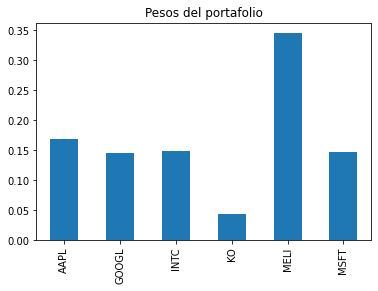

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(1).fit(train.fillna(0))
pc1 = pd.Series(index=train.columns, data=pca.components_[0])
weights = abs(pc1) / sum(abs(pc1))
weights.plot(kind = 'bar', title='Pesos del portafolio')

Los pesos del portafolio quedan como sigue (normalizados en %, por eejemplo AAPL llevaría 19%, GOOGL 16%)

In [ ]:
weights

AAPL     0.169668
GOOGL    0.145049
INTC     0.148779
KO       0.043520
MELI     0.345197
MSFT     0.147788
dtype: float64

Visualizo el portafolio desde finales 2018 hasta la fecha, viendo un retorno total acumulado de 240%

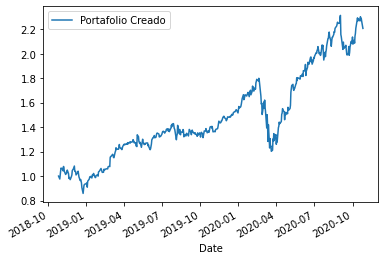

In [ ]:
my_portfolio_usd = (weights * returns_usd).sum(1)
my_portfolio_dataframe = pd.concat([my_portfolio_usd], 1)
my_portfolio_dataframe.columns = ["Portafolio Creado"]
my_portfolio_cumulative_returns = my_portfolio_dataframe.cumsum().apply(np.exp)
my_portfolio_cumulative_returns.plot(subplots=True);

Normalizo la data de los CDARS para que todos los precios expesen el mismo ratio de conversión durante todo el periodo que estamos trabajando

In [ ]:
weights_ars = weights.reset_index()
weights_ars['index'] = tickers_cdars
weights_ars.set_index('index', inplace = True)
weights_ars = weights_ars[0]

Tanto MELI como GOOGL cambiaron el ratio de conversión

In [ ]:
fecha_previa_conversion = prices_ars.index < '2020-10-22'
prices_ars['MELI.BA'] = np.where(fecha_previa_conversion, (prices_ars['MELI.BA'] * 2) / 60, prices_ars['MELI.BA'])

In [ ]:
fecha_previa_conversion = prices_ars.index < '2020-10-22'
prices_ars['GOOGL.BA'] = np.where(fecha_previa_conversion, (prices_ars['GOOGL.BA'] * 28) / 58, prices_ars['GOOGL.BA'])

In [ ]:
fecha_previa_conversion = prices_ars.index < '2020-10-22'
prices_ars['MSFT.BA'] = np.where(fecha_previa_conversion, (prices_ars['MSFT.BA'] * 5) / 10, prices_ars['MSFT.BA'])

Visualización del portafolio utilizando un capital inicial de 20 mil pesos desde finales del 2018. Se ve que habiendo invertido tan solo 20 mil pesos hace 2 años, a dia de hoy habrùamos acumulado 175.000 pesos en CDARS

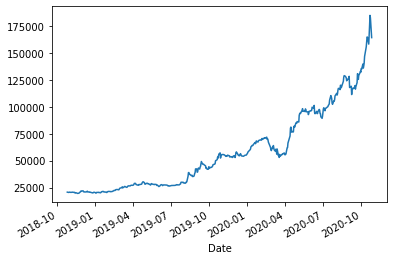

In [ ]:
my_portfolio_cumulative_returns = 50 * (weights_ars * prices_ars).sum(axis = 1)
my_portfolio_cumulative_returns.plot(subplots=True);

Hago una visualización final de los precios de cada CDAR por separado en todo el periodo. El modelo fue entrenado tan solo con la mitad del gráfico, pudiendo capturar datos para el futuro.

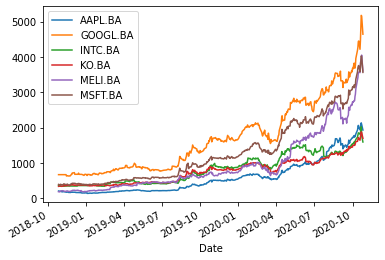

In [ ]:
prices_ars.plot()

Estudio para ingresar en el mercado

In [ ]:
intaday_bars = yf.download(' '.join(tickers_cdars), period = '5h', interval = '5m')

[*********************100%***********************]  6 of 6 completed


In [ ]:
intaday_bars.index[[0, -1]]

DatetimeIndex(['2020-10-26 12:00:00-03:00', '2020-10-26 16:55:00-03:00'], dtype='datetime64[ns, America/Argentina/Buenos_Aires]', name='Datetime', freq=None)

In [ ]:
intaday_bars = intaday_bars.dropna()

In [ ]:
intaday_bars.index[[0, -1]]

DatetimeIndex(['2020-10-26 12:00:00-03:00', '2020-10-26 16:55:00-03:00'], dtype='datetime64[ns, America/Argentina/Buenos_Aires]', name='Datetime', freq=None)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa87926eb70>,
      dtype=object)

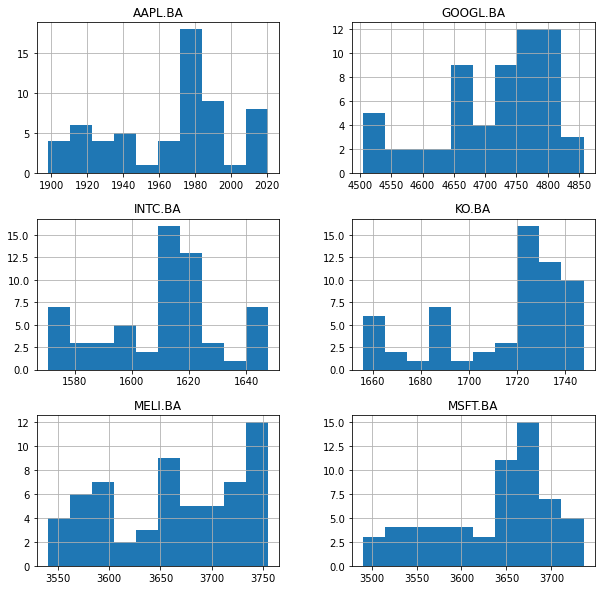

In [ ]:
((intaday_bars.High + intaday_bars.Low)/2).hist(figsize = (10, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8781817b8>,
      dtype=object)

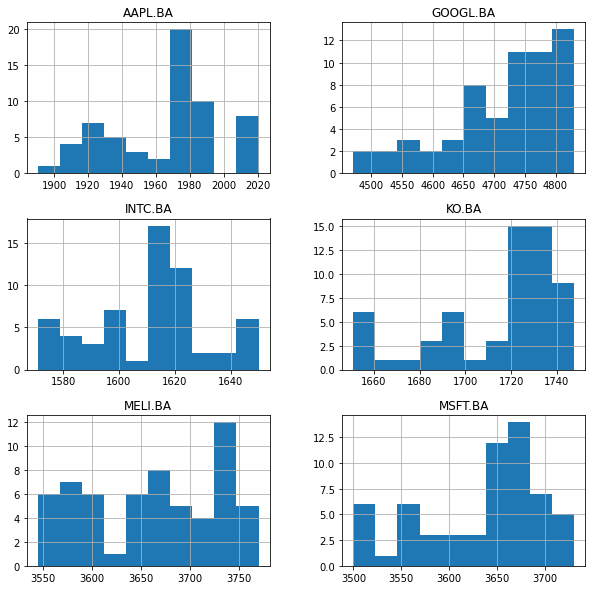

In [ ]:
(intaday_bars.Close).hist(figsize = (10, 10))

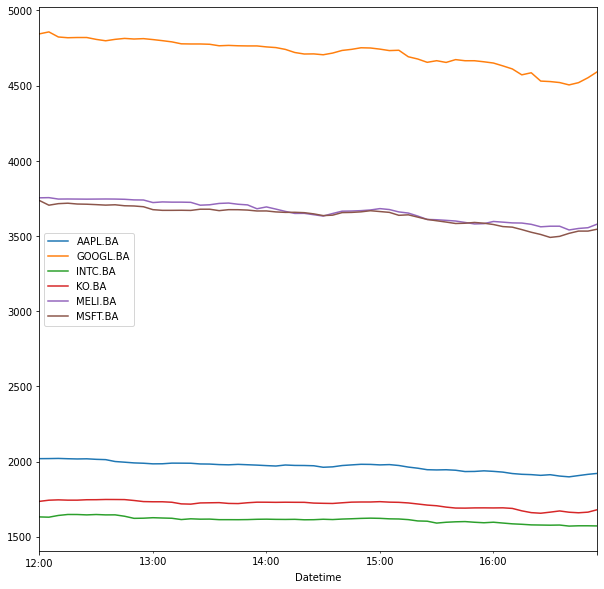

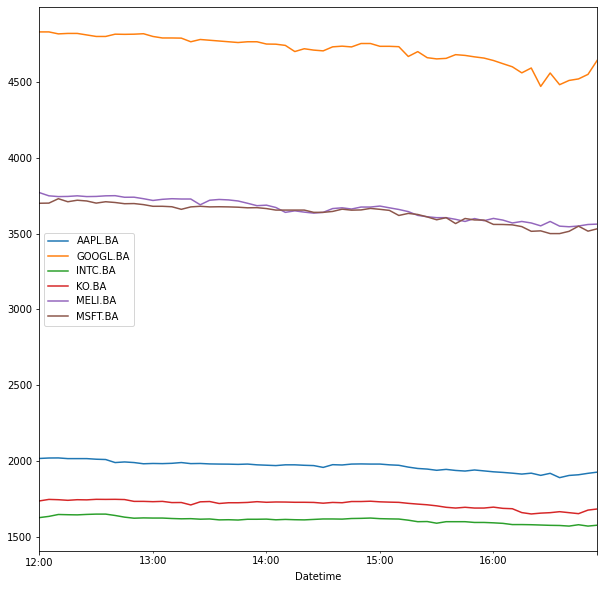

In [ ]:
((intaday_bars.High + intaday_bars.Low)/2).plot(figsize = (10, 10))
((intaday_bars.Close)).plot(figsize = (10, 10))

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
indexes = range(len(intaday_bars))
X = np.array(indexes).reshape(-1, 1)
y = intaday_bars.Close['MELI.BA']
lm_meli = LinearRegression().fit(X, y)

In [ ]:
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y, lm_meli.predict(X)))

17.225923188243314

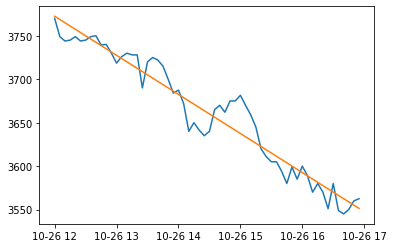

In [ ]:
import matplotlib.pyplot as plt

plt.plot(intaday_bars.Close.index, intaday_bars.Close['MELI.BA'])
plt.plot(intaday_bars.Close.index, lm_meli.predict(X))

In [ ]:
price = lm_meli.predict([[indexes[-1]]])
price

array([3551.35191257])

In [ ]:
initial_balance = 108606.7
weights_balance = weights_ars * initial_balance
weights_balance

index
AAPL.BA     18427.043684
MELI.BA     15753.338157
INTC.BA     16158.378710
KO.BA        4726.533556
GOOGL.BA    37490.681550
MSFT.BA     16050.724343
Name: 0, dtype: float64

Cantidad de papeles a comprar (debe ser redondeado hacia abajo)

In [ ]:
weights_balance['MELI.BA'] / price

array([4.43587077])